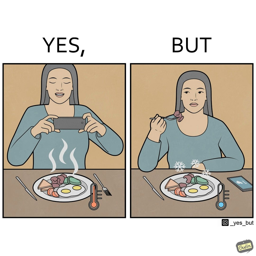

Yes


In [3]:
import random, json
from PIL import Image
import os

outputfile = "outputs/detection/first_round/gpt4-vision.json"
with open(outputfile, "r") as f:
    outputs = json.load(f)


image_path = random.choice(list(outputs.keys()))
output = outputs[image_path]
#assert ("left" in outputfile) == ("YES" in image_path)
display(Image.open(os.path.join("images",image_path)).convert('RGB').resize((256,256)))
print(output)

## Completion stats

In [12]:
def clean_value(value):
    """Clean the prediction or ground truth value."""
    value = value.strip().replace('"', '')  # Strip spaces and quotes
    if len(value) > 3:
        value = value[-2]  # Take the pred[-2] character if length > 3
    return value

def evaluate_performance(preds, ground_truths):

    # Initialize counters for true positives, false positives, true negatives, and false negatives
    tp, fp, tn, fn = 0, 0, 0, 0

    for key in preds:
        if not preds[key]:
            continue
        pred = clean_value(preds[key])
        true = clean_value(ground_truths[key])
        
        if pred == 'A' and true == 'A':
            tp += 1
        elif pred == 'A' and true == 'B':
            fp += 1
        elif pred == 'B' and true == 'B':
            tn += 1
        elif pred == 'B' and true == 'A':
            fn += 1

    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precisionA = tp / (tp + fp) if (tp + fp) > 0 else 0
    precisionB = tn / (tn + fn) if (tn + fn) > 0 else 0
    recallA = tp / (tp + fn) if (tp + fn) > 0 else 0
    recallB = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1A = 2 * (precisionA * recallA) / (precisionA + recallA) if (precisionA + recallA) > 0 else 0
    f1B = 2 * (precisionB * recallB) / (precisionB + recallB) if (precisionB + recallB) > 0 else 0

    macro_avg_precision = (precisionA+precisionB)/2
    weighted_avg_precision = (precisionA*(tp+fn)+precisionB*(tn+fp))/(tp+fp+tn+fn)

    macro_avg_recall = (recallA+recallB)/2
    weighted_avg_recall = (recallA*(tp+fn)+recallB*(tn+fp))/(tp+fp+tn+fn)  # should be same as accuracy

    macro_avg_f1 = (f1A+f1B)/2
    weighted_avg_f1 = (f1A*(tp+fn)+f1B*(tn+fp))/(tp+fp+tn+fn)
    
    # Print out the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision : (A): {precisionA:.4f}, (B): {precisionB:.4f}, (macro): {macro_avg_precision:.4f}, (weighted): {weighted_avg_precision:.4f}")
    print(f"Recall : (A): {recallA:.4f}, (B): {recallB:.4f}, (macro): {macro_avg_recall:.4f}, (weighted): {weighted_avg_recall:.4f}")
    print(f"F1 Score : (A): {f1A:.4f}, (B): {f1B:.4f}, (macro): {macro_avg_recall:.4f}, (wieghted): {weighted_avg_f1:.4f}")

# Example usage
#preds = {"1": " A", "2": "\"B\"", "3": "CAB", "4": " BA "}
#ground_truths = {"1": "A", "2": "B", "3": "A", "4": "B"}

evaluate_performance(real, gt)

Accuracy: 0.5867
Precision : (A): 0.4231, (B): 0.6210, (macro): 0.5220, (weighted): 0.5444
Recall : (A): 0.1897, (B): 0.8370, (macro): 0.5133, (weighted): 0.5867
F1 Score : (A): 0.2619, (B): 0.7130, (macro): 0.5133, (wieghted): 0.5386


In [11]:
with open("completion_groundtruth.json", "r") as f:
    gt = json.load(f)
with open("outputs/completion/gpt4-vision-zero.json", "r") as f:
    real = json.load(f)

In [ ]:
print(set(real.values()))
stats = {True: {"A": 0, "B": 0}, False: {"A": 0, "B": 0}}
for file,pred in real.items():
    pred = pred.strip('"')
    stats[pred==gt[file]][pred]+=1

print(stats)
nA_gt = sum(1 for r in gt.values() if r=="A")
print(f"gt A,B: {nA_gt, len(gt)-nA_gt}")
print(f"pred A,B: {sum(1 for r in real.values() if r=='A'), len(gt)-sum(1 for r in real.values() if r=='A')}")
print(f"accuracy: {sum(stats[True].values())/sum(sum(v.values()) for v in stats.values())}")
print(f"recallA: {stats[True]['A']/nA_gt}")
print(f"recallB: {stats[True]['B']/(len(gt)-nA_gt)}")

In [46]:
92/(92+58)

0.6133333333333333

### Zero shot

- (A,B) = (26, 124)
- Accuracy: 0.5867
- Precision : (A): 0.4231, (B): 0.6210, (macro): 0.5220, (weighted): 0.5444
- Recall : (A): 0.1897, (B): 0.8370, (macro): 0.5133, (weighted): 0.5867
- F1 Score : (A): 0.2619, (B): 0.7130, (macro): 0.5133, (wieghted): 0.5386

### COT

- (A,B) = (16, 134)
- Accuracy: 0.5733
- Precision : (A): 0.3125, (B): 0.6045, (macro): 0.4585, (weighted): 0.4916
- Recall : (A): 0.0862, (B): 0.8804, (macro): 0.4833, (weighted): 0.5733
- F1 Score : (A): 0.1351, (B): 0.7168, (macro): 0.4833, (wieghted): 0.4919

In [55]:
with open("outputs/completion/gpt4-vision-cot-full.json", "r") as f:
    real = json.load(f)

c = {"A": 0, "B": 0}
for v in real.values():
    c[v[-2]]+=1
print(c)

{'A': 16, 'B': 134}
